In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import networkx as nx
import igraph as ig
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix,average_precision_score,accuracy_score  
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

In [2]:
#load data 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv("/Users/alixvanhees/Documents/HIRB THESIS /HI-Small_Trans_subset.csv")
print(data.head())

          Timestamp  From Bank    Account  To Bank  Account.1  \
0  2022/09/09 12:02     348286  811C389E0   148016  811C53230   
1  2022/09/09 00:18      22345  801B0C870   215266  80FA67C30   
2  2022/09/06 10:33       1267  800E00D50       14  801ED33F0   
3  2022/09/02 11:32     138395  80E8DB8D0   238190  80F684920   
4  2022/09/01 05:49      43049  80FF89190      217  8101478B0   

   Amount Received Receiving Currency  Amount Paid Payment Currency  \
0          1439.79        Saudi Riyal      1439.79      Saudi Riyal   
1            33.09          US Dollar        33.09        US Dollar   
2           263.34               Yuan       263.34             Yuan   
3      17154983.76        Swiss Franc  17154983.76      Swiss Franc   
4          8499.22             Shekel      8499.22           Shekel   

  Payment Format  Is Laundering  
0    Credit Card              0  
1    Credit Card              0  
2            ACH              0  
3         Cheque              0  
4         Ch

In [3]:
#preprocessing
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Hour'] = data['Timestamp'].dt.hour
data['Date_Year'] = data['Timestamp'].dt.year
data['Date_Month'] = data['Timestamp'].dt.month
data['Date_Day'] = data['Timestamp'].dt.day

data.drop(columns=['Timestamp'], inplace=True)

# Combine Amount Paid and Amount Received 
data['Amount'] = data[['Amount Paid', 'Amount Received']].mean(axis=1)  
#make as string
data['Account'] = data['Account'].astype(str)
data['Account.1'] = data['Account.1'].astype(str)

# remove rows with no Account
data.dropna(subset=['Account', 'Account.1'], inplace=True)

target = data['Is Laundering'] 

In [7]:
# built a graph 
G = nx.DiGraph()
edges = list(zip(data["Account"], data["Account.1"], data["Amount"]))
G.add_weighted_edges_from(edges)
print(f"Aantal nodes: {G.number_of_nodes()}")
print(f"Aantal edges: {G.number_of_edges()}")

# Convert to igraph
G_ig = ig.Graph.TupleList(list(zip(data["Account"], data["Account.1"])), directed=True)

# calculate the networkfeatures
data["degree_centrality"] = data["Account"].map(dict(zip(G_ig.vs["name"], G_ig.degree()))).fillna(0)
pagerank_scores = G_ig.pagerank()
data["pagerank"] = data["Account"].map(dict(zip(G_ig.vs["name"], pagerank_scores))).fillna(0)

# Time feature
window_size = 50
data["rolling_24h_amount"] = data.groupby("Account")["Amount"].rolling(window_size).sum().reset_index(0, drop=True).fillna(0)

# transaction count
data["transaction_count"] = data.groupby("Account")["Amount"].transform("count")

# feature creation 
features = data.drop(columns=[
    'Is Laundering',
    'Payment Currency',
    'Receiving Currency'
]).copy()

features["degree_centrality"] = data["degree_centrality"]
features["pagerank"] = data["pagerank"]
features["rolling_24h_amount"] = data["rolling_24h_amount"]
features["transaction_count"] = data["transaction_count"]

Aantal nodes: 456048
Aantal edges: 781964


In [8]:
# Define Columns
numerical_cols = ['Amount', 'Hour', 'Date_Day','degree_centrality','pagerank','rolling_24h_amount','transaction_count']
categorical_cols = ['From Bank', 'Account','To Bank','Account.1']
target = 'Is Laundering'
#Split features abd target
X = data[numerical_cols + categorical_cols]
y = data[target].astype(float)

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # stratify 
)
# Further splitting the train set into Train and Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

In [9]:
#MINMAXSCALER 
#Scale numerical features (only fitting on train)
scaler = MinMaxScaler()
X_train_num = scaler.fit_transform(X_train[numerical_cols])
X_val_num = scaler.transform(X_val[numerical_cols])   # Only transform
X_test_num = scaler.transform(X_test[numerical_cols]) # Only transform

# Convert scaled numerical features to DataFrames
X_train_num_df = pd.DataFrame(X_train_num, columns=numerical_cols, index=X_train.index)
X_val_num_df = pd.DataFrame(X_val_num, columns=numerical_cols, index=X_val.index)
X_test_num_df = pd.DataFrame(X_test_num, columns=numerical_cols, index=X_test.index)

#LABEL ENCODER 

# Combine all data for encoding (to prevent unseen labels)
combined_data = pd.concat([X_train, X_val, X_test], axis=0)

# Initialize a dictionary to store LabelEncoders and vocad_sizes for each column
label_encoders = {}
vocab_sizes = {}

# Fit LabelEncoders on the combined dataset
for col in categorical_cols:
    le = LabelEncoder()
    combined_data[col] = le.fit_transform(combined_data[col].astype(str))
    label_encoders[col] = le  # Store the encoder

# Split the transformed data back into train, validation, and test sets
X_train_cat = combined_data.loc[X_train.index, categorical_cols].reset_index(drop=True)
X_val_cat = combined_data.loc[X_val.index, categorical_cols].reset_index(drop=True)
X_test_cat = combined_data.loc[X_test.index, categorical_cols].reset_index(drop=True)
# Convert the transformed categorical features to DataFrames
X_train_cat_df = pd.DataFrame(X_train_cat, columns=categorical_cols, index=X_train.index)
X_val_cat_df = pd.DataFrame(X_val_cat, columns=categorical_cols, index=X_val.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=categorical_cols, index=X_test.index)

# Calculate vocab sizes (based on the combined data)
for col in categorical_cols:
    vocab_sizes[col] = int(combined_data[col].max()) + 1  # +1 because categories are 0-indexed

# Combine numerical and categorical features
X_train_processed = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_val_processed = pd.concat([X_val_num_df, X_val_cat_df], axis=1)
X_test_processed = pd.concat([X_test_num_df, X_test_cat_df], axis=1)

# Display results
print("Processed Train Set Shape:", X_train_processed.shape)

Processed Train Set Shape: (1680000, 11)


In [10]:
#Best trial: value of optuna 
  #gamma: 4.529988306248537
  #beta: 0.14238185374092152
  #alpha: 0.3379069619030579
  #nnpu_gamma: 0.6853675205843353
  #lr: 0.002761123426508552
  #emb_dim: 8
  #hidden_size: 64
  #threshold: 0.35963994832994783
  #batch_size: 512

In [11]:
pi = 0.001  # prior over the full dataset (e.g. fraud prevalence)
label_fraction = 0.2  # 20% of positives are labeled

class PUDatasetEmbedding(Dataset):
    def __init__(self, X_num, X_cat, y_true, label_fraction, random_state=42):
        
        self.X_num = np.array(X_num)
        self.X_cat = np.array(X_cat)
        self.y_true = np.array(y_true)
        self.label_fraction = float(label_fraction)
        
        # Automatically create y_pu (Positive-Unlabeled Labels)
        self.y_pu = self._create_y_pu(self.y_true, self.label_fraction, random_state)
        
        # Print statistics
        labeled_count = self.y_pu.sum()
        total_positive = (self.y_true == 1).sum()
        print(f"Labeled Positives: {labeled_count} / {total_positive}")
        print(f"Unlabeled Positives: {total_positive - labeled_count}")
        print(f"Total Samples: {len(self.y_true)}")
    
    def _create_y_pu(self, y_true, label_fraction, random_state):
        np.random.seed(random_state)
        y_pu = np.zeros_like(y_true, dtype=int)
        
        # Identify positive samples
        positive_indices = np.where(y_true == 1)[0]
        n_labeled = int(float(label_fraction) * len(positive_indices))
        
        # Randomly select which positives will be labeled
        labeled_indices = np.random.choice(positive_indices, size=n_labeled, replace=False)
        y_pu[labeled_indices] = 1
        
        return y_pu
    
    def __len__(self):
        return len(self.X_num)

    def __getitem__(self, idx):
        x_num = torch.tensor(self.X_num[idx], dtype=torch.float32)
        x_cat = torch.tensor(self.X_cat[idx], dtype=torch.long)
        pu_label = torch.tensor(self.y_pu[idx], dtype=torch.float32)
        y_true = torch.tensor(self.y_true[idx], dtype=torch.float32)
        return x_num, x_cat, pu_label, y_true

In [12]:
pu_dataset = PUDatasetEmbedding(X_train_num, X_train_cat, y_train,label_fraction)

Labeled Positives: 342 / 1713
Unlabeled Positives: 1371
Total Samples: 1680000


In [13]:
def focal_loss_elementwise(y_pred, y_true, gamma=4.529988306248537, alpha=0.3379069619030579):
    """
    Returns focal loss per element (not reduced)
    """
    y_pred = torch.clamp(y_pred, 1e-7, 1. - 1e-7)
    ce = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
    loss = alpha_factor * ((1 - pt) ** gamma) * ce
    return loss


In [14]:
def nnpu_focal_loss(y_pred, y_true, prior=pi, gamma=4.529988306248537, alpha=0.3379069619030579, beta=0.14238185374092152, nnpu_gamma=0.6853675205843353):
    """
    nnPU with focal loss instead of BCE
    """
    # Masks
    mask_pos = y_true == 1
    mask_unl = y_true == 0
    
    #If no positives or no unlabeled, skip this batch
    if mask_pos.sum() == 0 or mask_unl.sum() == 0:
        return torch.tensor(0.0, requires_grad=True)

    # Positive risk
    loss_pos = focal_loss_elementwise(y_pred[mask_pos], torch.ones_like(y_pred[mask_pos]), gamma, alpha).mean()

    # Negative risk estimate from both P and U
    loss_neg_pos = focal_loss_elementwise(y_pred[mask_pos], torch.zeros_like(y_pred[mask_pos]), gamma, alpha).mean()
    loss_neg_unl = focal_loss_elementwise(y_pred[mask_unl], torch.zeros_like(y_pred[mask_unl]), gamma, alpha).mean()

    # Risk decomposition
    positive_risk = prior * loss_pos
    negative_risk = loss_neg_unl - prior * loss_neg_pos

    # Non-negative correction
    if negative_risk < -beta:
        total_loss = -nnpu_gamma * negative_risk
    else:
        total_loss = positive_risk + torch.clamp(negative_risk, min=0.0)

    return total_loss


In [15]:
class SimpleEmbeddingPUModel(nn.Module):
    def __init__(self, input_dim_numeric, vocab_sizes, emb_dim=8, hidden_size = 64):
        super().__init__()

        # Embedding layers for 4 categorical features
        self.emb_from = nn.Embedding(vocab_sizes['From Bank'], emb_dim)
        self.emb_account = nn.Embedding(vocab_sizes['Account'], emb_dim)
        self.emb_to = nn.Embedding(vocab_sizes['To Bank'], emb_dim)
        self.emb_account1 = nn.Embedding(vocab_sizes['Account.1'], emb_dim)

        # Total input: numerical + 4 embeddings
        self.fc = nn.Sequential(
            nn.Linear(input_dim_numeric + 4 * emb_dim, hidden_size),  # only 1 hidden layer
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )


    def forward(self, x_num, x_cat):
    # 🔍 Sanity check for embedding indices
        if (x_cat[:, 0] >= self.emb_from.num_embeddings).any():
            raise ValueError(f"'From Bank' index out of range: max {x_cat[:, 0].max().item()}, allowed < {self.emb_from.num_embeddings}")
        if (x_cat[:, 1] >= self.emb_account.num_embeddings).any():
            raise ValueError(f"'Account' index out of range: max {x_cat[:, 1].max().item()}, allowed < {self.emb_account.num_embeddings}")
        if (x_cat[:, 2] >= self.emb_to.num_embeddings).any():
            raise ValueError(f"'To Bank' index out of range: max {x_cat[:, 2].max().item()}, allowed < {self.emb_to.num_embeddings}")
        if (x_cat[:, 3] >= self.emb_account1.num_embeddings).any():
            raise ValueError(f"'Account.1' index out of range: max {x_cat[:, 3].max().item()}, allowed < {self.emb_account1.num_embeddings}")

        e1 = self.emb_from(x_cat[:, 0])
        e2 = self.emb_account(x_cat[:, 1])
        e3 = self.emb_to(x_cat[:, 2])
        e4 = self.emb_account1(x_cat[:, 3])
        x = torch.cat([x_num, e1, e2, e3, e4], dim=1)
        return self.fc(x)


In [16]:
dataloader = DataLoader(pu_dataset, batch_size=512, shuffle=True)
# Model
model = SimpleEmbeddingPUModel(
    input_dim_numeric=X_train_num.shape[1],
    vocab_sizes=vocab_sizes,
    emb_dim=8  # You can tune this
)

In [17]:
#training of the model 
optimizer = torch.optim.Adam(model.parameters(), lr=0.002761123426508552)

for epoch in range(10):
    model.train()
    total_loss = 0.0

    for x_num, x_cat, pu_label,y_true in dataloader:
        optimizer.zero_grad()
        y_pred = torch.sigmoid(model(x_num, x_cat).squeeze())
        loss = nnpu_focal_loss(y_pred, pu_label, prior=pi)  # or nnpu_focal_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}")


Epoch 1 - Loss: 0.0001
Epoch 2 - Loss: 0.0000
Epoch 3 - Loss: 0.0000
Epoch 4 - Loss: 0.0000
Epoch 5 - Loss: 0.0000
Epoch 6 - Loss: 0.0000
Epoch 7 - Loss: 0.0000
Epoch 8 - Loss: 0.0000
Epoch 9 - Loss: 0.0000
Epoch 10 - Loss: 0.0000


In [18]:
#evaluation
X_test_num_np = X_test_num.astype('float32')
X_test_cat_np = X_test_cat.to_numpy().astype('int64')

model.eval()

with torch.no_grad():
    x_num_tensor = torch.tensor(X_test_num_np, dtype=torch.float32)
    x_cat_tensor = torch.tensor(X_test_cat_np, dtype=torch.long)
    logits = model(x_num_tensor, x_cat_tensor).squeeze()  # Probabilities
    y_probs = torch.sigmoid(logits).numpy()
    y_pred = (y_probs >= 0.35963994832994783).astype(int)  # Binary predictions
# y_test = true labels, from your original split
y_true = y_test.values.astype(int)  # just in case it's float

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_probs)
pr_auc = average_precision_score(y_true, y_probs)

print("🔍 Evaluation Results:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")
print(f"PR AUC:    {pr_auc:.4f}") 


🔍 Evaluation Results:
Accuracy:  0.9977
Precision: 0.0238
Recall:    0.0305
F1 Score:  0.0268
ROC AUC:   0.6185
PR AUC:    0.0076


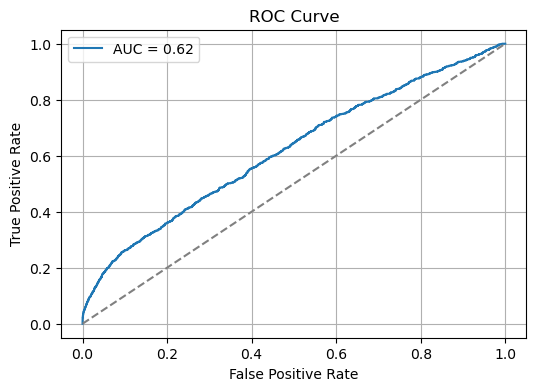

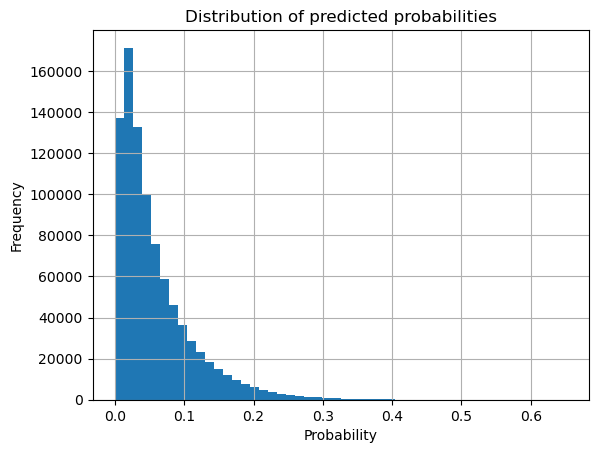

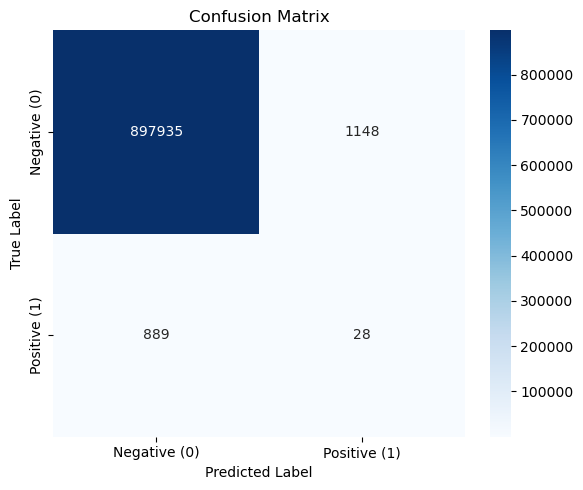

In [19]:
#plot of the ROC AUC curve 
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()
#plot distribution of predicted probabilities 
plt.hist(y_probs, bins=50)
plt.title("Distribution of predicted probabilities")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.grid()
plt.show()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Define labels
labels = ['Negative (0)', 'Positive (1)']
# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [51]:
#optuna
# Pre-compute validation tensors outside the objective function
x_val_num_tensor = torch.tensor(X_val_num, dtype=torch.float32).to(device)
x_val_cat_tensor = torch.tensor(X_val_cat.to_numpy().astype('int64'), dtype=torch.long).to(device)

def objective(trial,x_val_num_tensor, x_val_cat_tensor):
    #Sample hyperparameters
    gamma = trial.suggest_float('gamma', 1.0, 5.0)
    beta = trial.suggest_float('beta', 0.0, 0.2)
    alpha = trial.suggest_float("alpha", 0.1, 0.9)
    nnpu_gamma = trial.suggest_float("nnpu_gamma", 0.5, 2.0)
    lr = trial.suggest_float('lr', 1e-4, 0.3)
    emb_dim = trial.suggest_categorical('emb_dim', [4, 8, 16, 32])
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64, 128])
    threshold = trial.suggest_float('threshold', 0.1, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512, 1024])


    #Define model
    model = SimpleEmbeddingPUModel(
        input_dim_numeric=X_train_num.shape[1],
        vocab_sizes=vocab_sizes,
        emb_dim=emb_dim
    ).to(device)

    #Setup optimizer
    dataset = PUDatasetEmbedding(X_train_num, X_train_cat, y_train,label_fraction)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    #Create DataLoader
    loader = DataLoader(dataset, batch_size=int(batch_size), shuffle=True)

    #Training loop (shortened for tuning)
    model.train()
    for epoch in range(10):  # use fewer epochs for faster tuning
        for x_num, x_cat, pu_label, _ in loader:
            x_num, x_cat, pu_label = x_num.to(device), x_cat.to(device), pu_label.to(device)
            optimizer.zero_grad()
            y_probs = torch.sigmoid(model(x_num, x_cat).squeeze())
            loss = nnpu_focal_loss(y_probs, pu_label, prior=pi, beta=beta, gamma=gamma, alpha=alpha,nnpu_gamma=nnpu_gamma)
            if torch.isnan(loss): continue  # skip unstable batches
            loss.backward()
            optimizer.step()

    #Evaluate on Validation Set (not Test Set)
    model.eval()
    with torch.no_grad():
        logits = model(x_val_num_tensor, x_val_cat_tensor).squeeze()
        y_probs = torch.sigmoid(logits).cpu().numpy()
        y_probs = np.clip(y_probs, 0, 1) 
        y_pred = (y_probs >= threshold).astype(int)

    #Calculate F1 Score on Validation Set
    score = f1_score(y_val, y_pred)  # Use y_val, not y_test
    return score  #maximize this


In [52]:
study = optuna.create_study(direction='maximize')  # we're maximizing F1
study.optimize(lambda trial: objective(trial, x_val_num_tensor, x_val_cat_tensor), n_trials=10)
print("Best trial:")
trial = study.best_trial

for key, value in trial.params.items():
    print(f"  {key}: {value}")


[I 2025-05-13 09:19:10,945] A new study created in memory with name: no-name-0fd4fcfd-1c79-4a95-be99-45c9748b31c8


Labeled Positives: 342 / 1713
Unlabeled Positives: 1371
Total Samples: 1680000


[I 2025-05-13 09:29:54,414] Trial 0 finished with value: 0.016293279022403257 and parameters: {'gamma': 4.452844591660477, 'beta': 0.07366488170089867, 'alpha': 0.4551846413446117, 'nnpu_gamma': 0.5866473337327911, 'lr': 0.0022064428112690154, 'emb_dim': 4, 'hidden_size': 32, 'threshold': 0.421394558616066, 'batch_size': 256}. Best is trial 0 with value: 0.016293279022403257.


Labeled Positives: 342 / 1713
Unlabeled Positives: 1371
Total Samples: 1680000


[I 2025-05-13 09:51:29,631] Trial 1 finished with value: 0.035794183445190156 and parameters: {'gamma': 2.356017220579132, 'beta': 0.06303858327288274, 'alpha': 0.13466365325608853, 'nnpu_gamma': 0.9718855157210962, 'lr': 0.0016098543771382765, 'emb_dim': 32, 'hidden_size': 128, 'threshold': 0.35690353472005254, 'batch_size': 256}. Best is trial 1 with value: 0.035794183445190156.


Labeled Positives: 342 / 1713
Unlabeled Positives: 1371
Total Samples: 1680000


[I 2025-05-13 10:06:45,500] Trial 2 finished with value: 0.022838499184339313 and parameters: {'gamma': 3.809698960699325, 'beta': 0.12983008223768555, 'alpha': 0.19207074618092115, 'nnpu_gamma': 1.825730819336991, 'lr': 0.002105341437162727, 'emb_dim': 4, 'hidden_size': 64, 'threshold': 0.28288008706774004, 'batch_size': 256}. Best is trial 1 with value: 0.035794183445190156.


Labeled Positives: 342 / 1713
Unlabeled Positives: 1371
Total Samples: 1680000


[I 2025-05-13 10:25:46,431] Trial 3 finished with value: 0.04081632653061225 and parameters: {'gamma': 2.9589593828502387, 'beta': 0.14735826635382307, 'alpha': 0.1757712025959447, 'nnpu_gamma': 0.8937701804959729, 'lr': 0.00482104113026094, 'emb_dim': 4, 'hidden_size': 128, 'threshold': 0.36440100690836297, 'batch_size': 1024}. Best is trial 3 with value: 0.04081632653061225.


Labeled Positives: 342 / 1713
Unlabeled Positives: 1371
Total Samples: 1680000


[I 2025-05-13 10:35:15,013] Trial 4 finished with value: 0.024852071005917156 and parameters: {'gamma': 4.7298445258108, 'beta': 0.04931008029066506, 'alpha': 0.7693749745030498, 'nnpu_gamma': 1.553802679506869, 'lr': 0.004172580857778364, 'emb_dim': 4, 'hidden_size': 64, 'threshold': 0.41177395675852635, 'batch_size': 512}. Best is trial 3 with value: 0.04081632653061225.


Labeled Positives: 342 / 1713
Unlabeled Positives: 1371
Total Samples: 1680000


[I 2025-05-13 10:44:02,461] Trial 5 finished with value: 0.007980157446349617 and parameters: {'gamma': 3.3998562067954605, 'beta': 0.14153988438280674, 'alpha': 0.6846889258222923, 'nnpu_gamma': 1.999577455561296, 'lr': 0.002382193959604564, 'emb_dim': 16, 'hidden_size': 32, 'threshold': 0.15993856020972574, 'batch_size': 128}. Best is trial 3 with value: 0.04081632653061225.


Labeled Positives: 342 / 1713
Unlabeled Positives: 1371
Total Samples: 1680000


[I 2025-05-13 10:55:02,389] Trial 6 finished with value: 0.0448780487804878 and parameters: {'gamma': 4.529988306248537, 'beta': 0.14238185374092152, 'alpha': 0.3379069619030579, 'nnpu_gamma': 0.6853675205843353, 'lr': 0.002761123426508552, 'emb_dim': 8, 'hidden_size': 64, 'threshold': 0.35963994832994783, 'batch_size': 512}. Best is trial 6 with value: 0.0448780487804878.


Labeled Positives: 342 / 1713
Unlabeled Positives: 1371
Total Samples: 1680000


[I 2025-05-13 11:05:23,930] Trial 7 finished with value: 0.03344120819848975 and parameters: {'gamma': 1.1115758814896668, 'beta': 0.06736455263431416, 'alpha': 0.6121116838209212, 'nnpu_gamma': 0.7133846515672002, 'lr': 0.004933148785425647, 'emb_dim': 8, 'hidden_size': 128, 'threshold': 0.16364265635904246, 'batch_size': 512}. Best is trial 6 with value: 0.0448780487804878.


Labeled Positives: 342 / 1713
Unlabeled Positives: 1371
Total Samples: 1680000


[I 2025-05-13 11:15:24,066] Trial 8 finished with value: 0.03022670025188917 and parameters: {'gamma': 3.173397808039962, 'beta': 0.15455533188024487, 'alpha': 0.26248700860807384, 'nnpu_gamma': 1.1831763466495993, 'lr': 0.004683335014576066, 'emb_dim': 8, 'hidden_size': 128, 'threshold': 0.295510771596048, 'batch_size': 256}. Best is trial 6 with value: 0.0448780487804878.


Labeled Positives: 342 / 1713
Unlabeled Positives: 1371
Total Samples: 1680000


[I 2025-05-13 11:26:33,779] Trial 9 finished with value: 0.016657412548584122 and parameters: {'gamma': 4.218123673403138, 'beta': 0.18755607572283772, 'alpha': 0.7938639785228387, 'nnpu_gamma': 1.2466021050064304, 'lr': 0.0044333277902160175, 'emb_dim': 32, 'hidden_size': 32, 'threshold': 0.4173756863175532, 'batch_size': 128}. Best is trial 6 with value: 0.0448780487804878.


Best trial:
  gamma: 4.529988306248537
  beta: 0.14238185374092152
  alpha: 0.3379069619030579
  nnpu_gamma: 0.6853675205843353
  lr: 0.002761123426508552
  emb_dim: 8
  hidden_size: 64
  threshold: 0.35963994832994783
  batch_size: 512


In [62]:
np.save("nnPU_IBM_y_true.npy",y_true)
np.save("nnPU_IBM_y_pred.npy",y_pred)
np.save("nnPU_IBM_y_probs.npy",y_probs)